# IE2 Big Data Project (weilemar & vongrdir)

Im folgenden Jupyter Notebook wird der Code vorgestellt, welcher verwendet wurde um das [Homocide Report](https://www.kaggle.com/murderaccountability/homicide-reports) Dataset zu analysieren.
Der Auftraggeber auf Kaggle ist die Organisation [Murder Accountability Project](http://www.murderdata.org/). Diese Organisation möchte mit Hilfe grosser Datenmengen und analysen zu einer besseren Mordbekämpfung beitragen.

In den Daten, welche uns von Kaggle zur Verfügung gestellt werden, befinden sich 23 Attribute für 638‘454 Morde in Amerika von 1980-2014. Ziel des Kaggle Aufrages ist es, ein Muster in den Daten für "Serial-Killer" zu entdecken. Mit diesen Daten könnte man auch sehr viele, spannende Diagramme erstellen z.B. [Charts](https://www.kaggle.com/kathakaliseth/exploratory-analysis-homicide-report). Jedoch liegt unser Fokus in dieser Arbeit auf dem clustern von Daten.
Konkret möchten wir mit 2 verschiednen Daten Cluster mit K-Means erstellen. Einerseits verwenden wir die Rohdaten in One-hot-encoding Form. Andererseits verwenden wir Embeddings welche mit Hilfe unserers zuvor trainierten Autoencoder generiert werden. Wir möchten die resultierenden Cluster vergleichen und auf beiden Resultaten anschliessend noch mit Hilfe einer PCA herausfinden, welche Attribute ausschlaggebend waren.

Als erster Schritt muss das rohe Dataset über die folgende URL heruntergeladen werden:

In [4]:
%%bash
cd data
wget -O homocide-reports.zip https://github.com/vongruenigen/IE2-Project/raw/master/data/homicide-reports.zip
unzip -f homocide-reports.zip

Archive:  homocide-reports.zip


--2017-05-26 16:42:02--  https://github.com/vongruenigen/IE2-Project/raw/master/data/homicide-reports.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vongruenigen/IE2-Project/master/data/homicide-reports.zip [following]
--2017-05-26 16:42:03--  https://raw.githubusercontent.com/vongruenigen/IE2-Project/master/data/homicide-reports.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11010328 (10M) [application/octet-stream]
Saving to: ‘homocide-reports.zip’

     0K .......... .......... .......... .......... ..........  0%  811K 13s
    50K .......... .......... .......... .......... ..........  0% 1.88M 9s
   1

Nachdem das Dataset heruntergeladen und entpackt ist muss daraus mittels des preprocessing Skripts (für Original siehe scripts/preprocess_data.py) das eigentliche Dataset mit One-Hot Encoded Vektoren verwendet werden. Zuerst aber einige Hilfsfunktionen, Import von Bibliotheken und Definitionen von Konstanten.

In [ ]:
import os
import re
import sys
import time
import tensorflow as tf
import numpy as np
import contextlib

from collections import defaultdict
from operator import itemgetter
from os import path

# Constants for file names
PROJECT_HOME = '/media/dvg/Volume/Dropbox/ZHAW/IE2/Project'
RAW_DATA_PATH = 'data/database.csv'
PREPROCESSED_DATA_PATH = 'data/samples.csv'
EMBEDDINGS_DATA_PATH = 'data/embeddings.csv'

DEFAULT_TF_DEVICE = '/gpu:0' # change to "/cpu:0" if no GPU is available

# Hyperparameters for autoencoder
TRAINING_EPOCHS = 1
BATCH_SIZE = 128
DISPLAY_EPOCH = 1
DISPLAY_BATCH = 1000
HIDDEN_SIZE = 256
RESULTS_DIR = path.abspath(path.join(PROJECT_HOME, 'results'))

# Columns we are going to ignore in the dataset because they're redundant or non-informative
STRIP_COLS = ('Record ID', 'Agency Name', 'Agency Code', 'Year', 'Month', 'Record Source')

def camel_to_sneak(name):
    '''Convert a string from camel-case to sneak-case.'''
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def error(msg):
    '''Logs an error message and terminates the process.'''
    log(msg, level='error')

def log(msg, level='info'):
    '''Logs the given message with the given level.'''
    ts = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
    print('[%s][%s] %s' % (level.upper(), ts, msg))
    if level == 'error': sys.exit(2)
        

def get_next_batch(train_data, batch_size):
    new_batch = []

    for _ in range(batch_size):
        new_line = train_data.readline().strip('\n')

        if new_line == '':
            continue

        new_batch.append(np.array(list((map(float, new_line.split(';'))))))

    return np.stack(new_batch)

def get_input_size_and_length(data_f):
    input_size = len(data_f.readline().split(';'))
    data_f.seek(0)

    num_samples = sum([1 for _ in data_f])
    data_f.seek(0)

    return input_size, num_samples

@contextlib.contextmanager
def with_tf_session(device=DEFAULT_TF_DEVICE):
    with tf.device(device):
        with tf.Session() as session:
            yield session


In [ ]:
with open(RAW_DATA_PATH, 'r') as data_f:
    with open(PREPROCESSED_DATA_PATH, 'w+') as out_f:
        # Read headings
        columns = data_f.readline().strip('\n').split(',')
        col_values = defaultdict(list)
        last_idx = 0

        log('The following columns are filtered: %s' % ', '.join(STRIP_COLS))

        # Find all unique values for each row in the dataset
        # and store them in col_values.
        for i, line in enumerate(data_f):
            sample_values = line.strip('\n').split(',')

            for c, v in zip(columns, sample_values):
                if c in STRIP_COLS: continue
                if v not in col_values[c]: col_values[c].append(v)

            last_idx = i

        log('The number of distinct values for each column are:\n')

        sum_lines = last_idx+1
        sum_vec_entries = 0

        for c, v in col_values.items():
            log('  %s = %d' % (c, len(v)))
            sum_vec_entries += len(v)

        log('The generated vectors will have a total of %d entries each' % sum_vec_entries)
        log('The dataset has %i samples' % sum_lines)

        data_f.seek(0)
        data_f.readline() # skip headings after seek(0)

        start_time = time.time()
        curr_idx = 0
        temp_x = []

        for i, line in enumerate(data_f):
            sample_values = line.strip('\n').split(',')
            sample_vec = np.zeros(sum_vec_entries)
            idx_offset = 0

            for c, v in zip(columns, sample_values):
                if c in STRIP_COLS: continue
                sample_vec[col_values[c].index(v)+idx_offset] = 1
                idx_offset += len(col_values[c])

            temp_x.append(sample_vec)

            if (i+1) % 100000 == 0 or (i+1) == sum_lines:
                temp_x = np.array(temp_x)
                np.random.shuffle(temp_x)

                log('Processed %i samples (%.1f%%)...' % (i+1, 100*(float(i+1)/sum_lines)))
                log('Storing collected data in CSV file...')

                temp_x_str = []

                for i in range(temp_x.shape[0]):
                    temp_x_str.append(';'.join(map(str, map(int, temp_x[i]))))
           
                out_f.write('%s\n' % '\n'.join(temp_x_str))

                curr_idx += temp_x.shape[0]

                log('Stored data successfully! (Took %.2fs)' % (time.time() - start_time))
                start_time = time.time()
                temp_x = []

        log('Successfully stored preprocessed samples in: %s' % PREPROCESSED_DATA_PATH)


Das Skript konvertiert alle Morde in _database.csv_ in One-Hot Encoded Vektoren und speichert diese in einer CSV Datei. Diese können dann verwendet werden um damit den _AutoEncoder_ zu trainieren und danach Embeddings für jeden einzelnen Mord zu generieren.

Beim Preprocessen werden alle Spalten berücksichtigt ausser diejenigen, welche in der Liste STRIP_COLS explizit ausgeschlossen werden. Das ganz funktioniert so, dass zuerst für jede Spalte eruiert wird, wieviele unterschiedliche Werte es pro Spalte hat. Wenn für eine Spalte _n_ verschiedene Werte vorhanden sind, so werden für die Darstellung im One-Hot Vektor entsprechend _n_ Werte für diese Spalte benötigt. Die resultierenden Vektoren sind also 

$$\sum_{c \in Columns} \operatorname{classes}(c)$$

lang, wobei _C_ für die Menge aller Spalten und _classes_ für die Anzahl unterschiedlicher Werte für die Spalte _c_ steht. Pro Zeile und Spalte werden dann diejenigen Werte, welche in der jeweiligen Zeile stehen auf _1_ gesetzt, alle anderen werden auf _0_ belassen. Als nächste folgt der Code in [TensorFlow](https://www.tensorflow.org/), welcher für die Implementation des _AutoEncoder_ und des _VariationalAutoEncoder_ zuständig ist.

Prinzipell sind _AutoEncoder_ eine spezielle Art von Neuronalen Netzen (NN), welche dafür zuständig sind, eine effiziente Codierung der Eingabedaten zu lernen. Der Aufbau ist so, dass die Eingabedaten als One-Hote Encoded Vektoren (im Bild unten _x_) über den Input Layer in das NN eingespeist wird. Diese werden dann mithilfe einer Multiplikation mit einer Gewichts-Matrix in den Hidden Layer projeziert. Dieser ist im Falle von AutoEncodern **immer** kleiner wie der Input Layer, weil das NN ja eine effiziente Codierung der Eingabedaten lernen soll. Am Ende wird das NN mithilfe von Gradient-Descent mit dem _Adam_ Optimierer darauf trainiert, aus der codierten Darstellung der Eingabedaten (im Bild unten _z_) wieder die Eingabedaten _x_ zu rekonstruieren. Die generierten Darstellungen _z_ können dann als Embeddings der Eingabedaten in einem _m_-dimensionalen Vektorraum aufgefasst werden, wobei _m_ der grösse des Hidden Layer in der Mitte entspricht. Auf diese Embeddings können wir dann später Clustering-Algorithmen anwenden um festzustellen, welche Verbrechen im eingebetteten Vektor-Raum nahe beieinander liegen.

![AutoEncoder Struktur](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)

Der Unterschied eines "normalen" _AutoEncoder_ zu einem _VariationalAutoEncoder_ liegt darin, dass es ein generatives Model ist ähnlich wie Adversarian Neuronale Netzwerke. Für eine gute Einführung in _VariationalAutoEncoder_ kann [dieses](http://kvfrans.com/variational-autoencoders-explained/) Tutorial hinzugezogen werden.

Wir werden alle Experimente mit beiden Varianten _AutoEncoder_ und _VariationalAutoEncoder_ durchführen. Unten folgt die Defintion der Modelle in Python mithilfe von TensorFlow.

In [ ]:
import tensorflow as tf

# The current version of the autoencoder to use
CurrentAutoEncoder = AutoEncoder

class AutoEncoder(object):
    def __init__(self, input_size, hidden_size, session):
        '''Initializes a new instance of the VariationalAutoencoder class.'''
        self.session = session
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weights = {}
        self.transfer_fn = tf.nn.softplus

        self.__initialize()
        self.__build()

    def __initialize(self):
        '''Initializes the weights needed to build the computational graph.'''
        weights = {}

        weights['weights_1'] = tf.get_variable('weights_1',[self.input_size, self.hidden_size])
        weights['bias_1'] = tf.Variable(tf.zeros([self.hidden_size], dtype=tf.float32))
        weights['weights_2'] = tf.Variable(tf.zeros([self.hidden_size, self.input_size], dtype=tf.float32))
        weights['bias_2'] = tf.Variable(tf.zeros([self.input_size], dtype=tf.float32))

        self.weights = weights

    def get_optimizer(self):
        '''Returns the optimizer for this instance.'''
        return self.optimizer

    def get_loss(self):
        '''Returns the loss function for this instance.'''
        return self.loss_fn

    def get_weights_and_biases(self):
        '''Returns the weights and biases of this instance.'''
        return self.weights

    def get_internal_representation(self):
        '''Returns the internal, embedded representation variables.'''
        return self.hidden

    def batch_fit(self, input):
        '''Fits the model to the given batch.'''
        loss, _ = self.session.run((self.loss_fn, self.optimizer),
                                   feed_dict={self.input: input})
        return loss

    def transform(self, input):
        return self.session.run(self.hidden, feed_dict={self.input: input})

    def __build(self):
        '''Builds the computational graph.'''
        self.input = tf.placeholder(tf.float32, [None, self.input_size])

        hidden_1_result = tf.matmul(self.input, self.weights['weights_1'])
        self.hidden = self.transfer_fn(tf.add(hidden_1_result,
                                              self.weights['bias_1']))

        reconstruction_result = tf.matmul(self.hidden, self.weights['weights_2'])
        self.reconstruction = tf.add(reconstruction_result, self.weights['bias_2'])

        diff = tf.subtract(self.reconstruction, self.input)
        self.loss_fn = 0.5 * tf.reduce_sum(tf.pow(diff, 2.0))
        self.optimizer_fn = tf.train.AdamOptimizer(learning_rate=0.001)
        self.optimizer = self.optimizer_fn.minimize(self.loss_fn)

class VariationalAutoencoder(object):
    def __init__(self, input_size, hidden_size, session):
        '''Initializes a new instance of the VariationalAutoencoder class.'''
        self.session = session
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weights = {}

        self.__initialize()
        self.__build()

    def __initialize(self):
        '''Initializes the weights needed to build the computational graph.'''
        weights = {}

        weights['weights_1'] = tf.get_variable('weights_1',[self.input_size, self.hidden_size])
        weights['log_sigma_weights_1'] = tf.get_variable('log_sigma_weights_1', [self.input_size, self.hidden_size])
        weights['bias_1'] = tf.Variable(tf.zeros([self.hidden_size], dtype=tf.float32))
        weights['log_sigma_bias_1'] = tf.Variable(tf.zeros([self.hidden_size], dtype=tf.float32))
        weights['weights_2'] = tf.Variable(tf.zeros([self.hidden_size, self.input_size], dtype=tf.float32))
        weights['bias_2'] = tf.Variable(tf.zeros([self.input_size], dtype=tf.float32))

        self.weights = weights

    def get_optimizer(self):
        '''Returns the optimizer for this instance.'''
        return self.optimizer

    def get_loss(self):
        '''Returns the loss function for this instance.'''
        return self.loss_fn

    def get_weights(self):
        '''Returns the weights of this instance.'''
        return self.weights

    def get_internal_representation(self):
        '''Returns the internal, embedded representation variables.'''
        return self.z

    def batch_fit(self, input):
        '''Fits the model to the given batch.'''
        loss, _ = self.session.run((self.loss_fn, self.optimizer),
                                   feed_dict={self.input: input})
        return loss

    def transform(self, input):
        return self.session.run(self.z_mean, feed_dict={self.input: input})

    def partial_fit(self, X):
        loss, opt = self.sess.run((self.loss_fn, self.optimizer), feed_dict={self.x: X})
        return loss

    def transform(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def __build(self):
        '''Builds the computational graph.'''
        self.input = tf.placeholder(tf.float32, [None, self.input_size])

        hidden_1_result = tf.matmul(self.input, self.weights['weights_1'])
        self.z_mean = tf.add(hidden_1_result, self.weights['log_sigma_bias_1'])

        log_sigma_result = tf.matmul(self.input, self.weights['log_sigma_weights_1'])
        self.z_log_sigma_sq = tf.add(log_sigma_result, self.weights['log_sigma_bias_1'])

        eps = tf.random_normal(tf.stack([tf.shape(self.input)[0], self.hidden_size]), 0, 1, dtype=tf.float32)
        self.z = tf.add(self.z_mean, tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        y_result = tf.matmul(self.z, self.weights['weights_2'])
        self.y = tf.add(y_result, self.weights['bias_2'])

        reconstruction_loss = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.y, self.input), 2.0))
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq \
                                           - tf.square(self.z_mean) \
                                           - tf.exp(self.z_log_sigma_sq), 1)

        self.loss_fn = tf.reduce_mean(reconstruction_loss + latent_loss)
        self.optimizer_fn = tf.train.AdamOptimizer(learning_rate=0.001)
        self.optimizer = self.optimizer_fn.minimize(self.loss_fn)


Nach der Definition der Modelle folgt der Code um diese zu trainieren. Das Training durchzuführen dauert entsprechend lange, auf einer mittelmässigen GPU benötigt es ca. einen Tag Rechenzeit. Im folgenden Abschnitt ist der Code, welcher zuständig ist für das Training des _AutoEncoder_, ersichtlich:

In [ ]:
# The current version of the autoencoder to use
CurrentAutoEncoder = AutoEncoder

encoder_type = camel_to_sneak(CurrentAutoEncoder.__name__)
time_stamp = time.strftime('%Y-%m-%d_%H-%M-%S', time.localtime())
result_name = '%s-%s-results/' % (time_stamp, encoder_type)
result_path = path.join(RESULTS_DIR, result_name)
model_path = path.join(result_path, 'model')
loss_track = []

if not path.isdir(result_path):
    os.mkdir(result_path)

with with_tf_session() as session:
    with open(PREPROCESSED_DATA_PATH, 'r') as train_f:
        input_size, num_samples = get_input_size_and_length(train_f)

        log('Starting training with a %s' % CurrentAutoEncoder.__name__)

        autoencoder = CurrentAutoEncoder(input_size, HIDDEN_SIZE, session=session)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=3)

        session.run(tf.global_variables_initializer())

        for epoch in range(TRAINING_EPOCHS):
            log('Starting epoch #%d' % (epoch+1))
            num_batches = int(num_samples / BATCH_SIZE)
            avg_loss = 0

            for num_batch in range(num_batches):
                batch_x = get_next_batch(train_f, BATCH_SIZE)
                loss = autoencoder.batch_fit(batch_x)
                avg_loss += (loss / num_samples) * BATCH_SIZE

                if (num_batch+1) % DISPLAY_BATCH == 0 or (num_batches-num_batch) < 5:
                    log('Batch #%d of #%d, loss = %.5f' % (num_batch+1, num_batches, loss))

            if (epoch+1) % DISPLAY_EPOCH == 0 or (epoch+1) == TRAINING_EPOCHS:
                log('Epoch #%d of #%d, loss = %.5f' % (epoch+1, TRAINING_EPOCHS, avg_loss))
                saver.save(session, result_path)


Nachdem der _AutoEncoder_ trainiert wurde kann dieser verwendet werden um damit die Embeddings für die einzelnen Verbrechen zu generieren:

In [1]:
with with_tf_session() as session:
    with open(PREPROCESSED_DATA_PATH, 'r') as samples_f:
        with open(EMBEDDINGS_DATA_PATH, 'w+') as emb_f:
            input_size, num_samples = get_input_size_and_length(train_f)
            log('Restoring model from %s' % model_path)

            autoencoder = CurrentAutoEncoder(input_size, HIDDEN_SIZE, session=session)

            saver = tf.train.Saver(tf.global_variables(), max_to_keep=3)
            saver.restore(session, model_path)

            log('Finished restoring the model')
            log('Starting to embed the samples in %s' % samples_path)

            num_batches = int(num_samples / BATCH_SIZE)

            for num_batch in range(num_batches):
                batch_x = get_next_batch(samples_data, num_batch)
                batch_y = autoencoder.transform(batch_x)

                for y in batch_y:
                    emb_f.write('%s\n' % ';'.join(map(str, y)))

                if (num_batch+1) % DISPLAY_BATCH == 0:
                    log('Processed %d of %d samples' % (num_batch+1, num_batches))


NameError: name 'with_tf_session' is not defined

Nun, da wir die Embeddings für alle Verbrechen generiert haben, können wir damit starten das K-Means Clustering auf diese anzuwenden, als auch auf die ursprünglichen One-Hot Encoded Vektoren, welche verwendet wurden um den _AutoEncoder_ zu trainieren.
Als erstes möchten wir mit der Elbow Curve die Clustergrössen herausfinden. Dazu berechneten wir die quadrierten Distanzen zum Schwerpunkt des Clusters und dies pro Clustergrösse. Diesen Vorgang führten wir zwei Mal durch. Einmal für die Daten in one hot encoding Form und einmal mit den Embeddings, welche mit den Daten generiert wurden.

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.mllib.clustering import KMeans
from numpy import array

import multiprocessing
import json
import math

APP_NAME = 'IE2-Project-Homocide-Reports'
INPUT_DATA = "C:/Users/MWeil/Documents/GitHub/IE2-Project/emb/emb-out.txt"
OUTPUT_PATH = "C:/Users/MWeil/Documents/GitHub/IE2-Project/results/kmeans_elbowCurve"

def run_kmeans(sc):
    cpu_count = multiprocessing.cpu_count()
    cluster_loss = dict()

    # Loads data.
    for n in range(2, 10):
        print("Start first iteration with %d clusters " % n)
        dataset = sc.textFile(INPUT_DATA, cpu_count)
        dataset = dataset.map(lambda line: array([float(x) for x in line.split(';')]))

        # Trains a k-means model.all
        clusters = KMeans.train(dataset, n)

        def error(point):
            center = clusters.centers[clusters.predict(point)]
            return math.sqrt(sum([x**2 for x in (point - center)]))

        # Evaluate clustering by computing Within Set Sum of Squared Errors.
        wssse = dataset.map(lambda x: error(x)).reduce(lambda x, y: x+y)
        print("Within Set Sum of Squared Errors = " + str(wssse))

        clusters.save(sc, OUTPUT_PATH + "_%d" % n)
        cluster_loss[n] = wssse

    # Write Cluster/loss pairs into json file
    with open(OUTPUT_PATH + ".json", 'w') as out_f:
        json.dump(cluster_loss, out_f)


if __name__ == "__main__":
    conf = SparkConf().setAppName(APP_NAME)
    conf.setMaster('local[*]')
    sc = SparkContext(conf=conf)
    run_kmeans(sc)

# Resultierende Werten
kmeans_oneHot = {2: 1882239.7127967812, 3: 1819390.0366607725, 4: 1781166.130537021, 5: 1790154.159369021, 6: 1751563.8476939967, 7: 1726611.2264736653, 8: 1723001.4344866727, 9: 1699032.8139749556}
kmeans_emb = {2: 29827.993347213996, 3: 29022.6267378454, 4: 28539.378887554467, 5: 28499.70978934842, 6: 28423.15224189341, 7: 27647.91119955642, 8: 27505.274130764727, 9: 27182.86597929387}
print("Resultierende kmeans Fehler mit one hot encoding Daten" + kmeans_oneHot)
print("Resultierende kmeans Fehler mit Embedding Daten" + kmeans_emb)

ImportError: No module named 'pyspark'

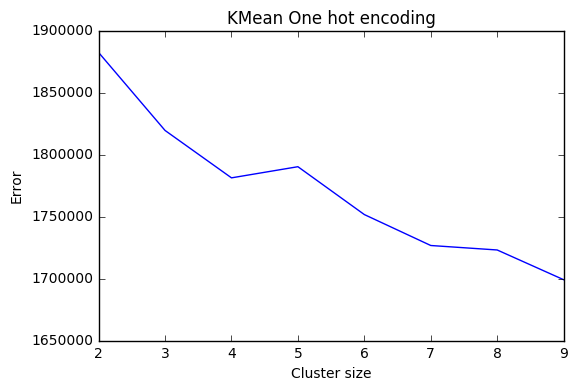

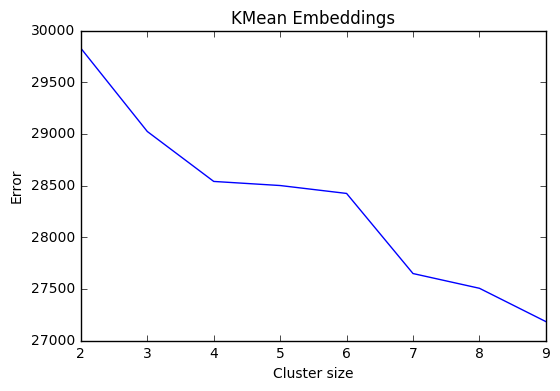

In [13]:
import matplotlib.pyplot as plt
lists_oneHot = sorted(kmeans_oneHot.items())
lists_emb = sorted(kmeans_emb.items())
x1, y1 = zip(*lists_oneHot)
x2, y2 = zip(*lists_emb)
plt.plot(x1, y1)
plt.title('KMeans One hot encoding')
plt.xlabel('Cluster size')
plt.ylabel('Error')
plt.show()
plt.plot(x2, y2)
plt.title('KMeans Embeddings')
plt.xlabel('Cluster size')
plt.ylabel('Error')
plt.show()

Was sofort auffällt, ist der grosse Unterschied der Werte. Der Berechnete Fehler nach dem Clustern mit K-Means ist für die One hot encoding Daten im Millionenbereich. Dies könnte an einzelnen Atttributen liegen wie z.B. Incidents oder city, welche im Vergleich mit knapp über 1000 verschiedenen Werten, deutlich mehr Klassen besitzen. Es scheint auch naheliegend dass die euklidsche Distanz einen kleineren Vektorraum im Vergleich begünstigt. Wir entdeckten eine API welche K-Modes heisst. Diese API wäre spezialisiert auf gemischte Daten (Klassen und diskrete Werte). Jedoch bemerkten wir leider beim ersten Test bereits, dass die Berechnung extrem lange dauern würde. Deshalb können wir diese Lösung nur hier am Rande erwähnen.

Wie auch immer, unsere ElbowCurce haben wir für Clustergrössen von 2 bis 9 generiert, die Begrenzung bei 9 ist nötig, da die Rechenzeit mit der Clustergrösse stark zunimt. Dies könnte teilweise auch an unserem Datensatz mit über 600'000 Einträgen mit jeweils 23 Attributen liegen.
Wir entscheiden uns nun für eine Clustergrösse von 7. Wir sehen dies als eine vernünftige Grösse und möchten nun herausfinden, aufgrund welcher Attribute diese 7 Cluster generiert werden. Dazu verwenden wie in der Projektbeschreibung vorgeschlagen, die PCA. Dafür teilen wir in einem ersten Schritt die Datensätze den jeweiligen Cluster zu.

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array

import multiprocessing
import json
import os

APP_NAME = 'IE2-Project-Homocide-Reports'
INPUT_DATA = "C:/Users/MWeil/Documents/GitHub/IE2-Project/data/homicide-reports/database_new.csv"
def run_kmeans(sc):
    cpu_count = multiprocessing.cpu_count()

    # Load Data
    dataset = sc.textFile(INPUT_DATA, cpu_count)
    dataset = dataset.map(lambda line: array([float(x) for x in line.split(';')]))

    # Load Model
    sameModel = KMeansModel.load(sc, "C:/Users/MWeil/Documents/GitHub/IE2-Project/one-hot-clustering/kmeans_model_7")

    # Predict cluster labels per row
    labels = sameModel.predict(dataset).collect()

    # Save labels in json file
    with open("C:/Users/MWeil/Documents/GitHub/IE2-Project/data/homicide-reports/database_new_label.json", 'w') as out_f:
        json.dump(labels, out_f)

if __name__ == "__main__":
    conf = SparkConf().setAppName(APP_NAME)
    conf.setMaster('local[*]')
    sc = SparkContext(conf=conf)
    run_kmeans(sc)
